## 1.import library

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp

## 2.Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                            )

In [7]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read Feed
        ret, frame = cap.read()

        # Make detection
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [6]:
draw_styled_landmarks(frame, results)

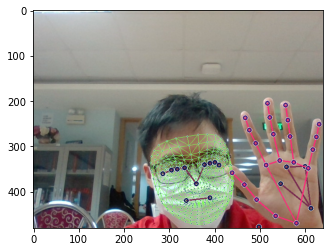

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
results.pose_landmarks.landmark[0]

x: 0.5626320242881775
y: 0.7963106036186218
z: -1.1767802238464355
visibility: 0.9992912411689758

## 3.Extract Keypoint Values

In [ ]:
len(results.pose_landmarks.landmark)

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in 
                        results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in 
                        results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh   = np.array([[res.x, res.y, res.z] for res in 
                        results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh   = np.array([[res.x, res.y, res.z] for res in 
                        results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [11]:
result_test = extract_keypoints(results);result_test

array([ 0.56263202,  0.7963106 , -1.17678022, ...,  0.        ,
        0.        ,  0.        ])

In [12]:
np.save('input', result_test)

In [13]:
np.load('input.npy')

array([ 0.60916722,  0.57045406, -1.36664701, ...,  0.11937565,
        0.37231448, -0.03897635])

## 4.Setup Folders for Collection

In [16]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('.\\action_data_2')
if not os.path.exists(DATA_PATH): os.makedirs(DATA_PATH)
# Actions that we try to detect
actions = np.array(['like' , 'dislike', 'bye', 'love'])

# Thirty videos worth of data
no_sequences = 50

# Videos are going to be 30 frames in length
sequence_length = 30

for action in actions:
    ac_path = os.path.join(DATA_PATH, action)
    if not os.path.exists(ac_path): os.makedirs(ac_path)

In [17]:
for action in actions:
    if len(np.array(os.listdir(os.path.join(DATA_PATH, action)))) > 0:
        dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    else: dirmax = 0
    for sequence in range(1,no_sequences+1):
        seq_path = os.path.join(DATA_PATH, action, str(dirmax+sequence))
        try: 
            if not os.path.exists(seq_path): 
                os.makedirs(seq_path)
        except:
            pass

## 5.Collect Keypoints Values for Training and Testing

In [18]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    is_break = False
    for action in actions:
        if is_break: break
        # Loop through sequences aka videos
        for sequence in range(1, no_sequences+1):
            if is_break: break
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                if is_break: break
                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    is_break = True
                    break    
    cap.release()
    cv2.destroyAllWindows()

# 6.Build model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
import tensorflow as tf

In [7]:
actions = np.array(['like' , 'dislike', 'bye', 'love'])

In [173]:
#model best 1, like, bye, love, best 4
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dense(actions.shape[0], activation='softmax'))

In [99]:
#model best 2, like, dislike, love
model = Sequential()
model.add(LSTM(20, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(40, return_sequences=False, activation='relu'))
model.add(Dense(40, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dense(20, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dense(actions.shape[0], activation='softmax'))

In [20]:
#model best 3
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(40, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dense(20, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dense(actions.shape[0], activation='softmax'))

In [19]:
# 0.68 valid
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(32, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dropout(0.3))
model.add(Dense(actions.shape[0], activation='softmax'))

In [25]:
# 0.78 valid, best 5
model = Sequential()
model.add(LSTM(256, dropout=0.5, input_shape=(30,1662)))
model.add(Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

In [13]:
# best 6
model = Sequential()
model.add(LSTM(256, dropout=0.5, input_shape=(30,1662)))
model.add(Dense(64 ,kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

In [8]:
# best 7, best 8
model = Sequential()
model.add(LSTM(256, input_shape=(30,1662)))
model.add(Dropout(0.9))
model.add(Dense(actions.shape[0], activation='softmax'))

In [23]:
model = Sequential()
model.add(LSTM(2048, dropout=0.5, input_shape=(30,1662)))
model.add(Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

In [36]:
model = Sequential()
model.add(LSTM(256, dropout=0.5, input_shape=(30,1662)))
model.add(Dense(64 ,kernel_initializer=tf.keras.initializers.HeUniform()))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

In [103]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(30,1662)))
model.add(Dropout(0.9))
model.add(Dense(actions.shape[0], activation='softmax'))

In [141]:
model = Sequential()
model.add(LSTM(256, input_shape=(30,1662)))
model.add(Dropout(0.9))
model.add(Dense(actions.shape[0], activation='softmax'))

In [61]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 256)               1965056   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 1,966,084
Trainable params: 1,966,084
Non-trainable params: 0
_________________________________________________________________


# Train model

In [17]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('E:\\code_python\\action_recognition\\action_data_2') 
DATA_TEST = os.path.join('E:\\code_python\\action_recognition\\action_data_1') 
# Actions that we try to detect
actions = np.array(['like' , 'dislike', 'bye', 'love'])

In [18]:
label_map = {label:num for num, label in enumerate(actions)}
sequence_length = 30

In [19]:
sequences_train, labels_train, sequences_test, labels_test = [], [], [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_train.append(window)
        labels_train.append(label_map[action])
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_TEST, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_TEST, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])

In [20]:
from tensorflow.keras.utils import to_categorical

In [21]:
X_train = np.array(sequences_train)
y_train = to_categorical(labels_train).astype(int)
X_test = np.array(sequences_test)
y_test = to_categorical(labels_test).astype(int)

In [80]:
y_train.shape

(200, 4)

In [81]:
y_test.shape

(200, 4)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stopping = EarlyStopping(
    min_delta=0, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [159]:
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=200, callbacks=[early_stopping])

Epoch 1/200
7/7 [==============================] - 3s 506ms/step - loss: 0.3508 - categorical_accuracy: 0.8600 - val_loss: 1.1754 - val_categorical_accuracy: 0.6100
Epoch 2/200
7/7 [==============================] - 3s 422ms/step - loss: 0.2966 - categorical_accuracy: 0.9250 - val_loss: 0.8164 - val_categorical_accuracy: 0.6450
Epoch 3/200
7/7 [==============================] - 3s 403ms/step - loss: 0.2643 - categorical_accuracy: 0.9100 - val_loss: 1.0089 - val_categorical_accuracy: 0.6350
Epoch 4/200
7/7 [==============================] - 3s 392ms/step - loss: 0.2583 - categorical_accuracy: 0.9400 - val_loss: 1.1558 - val_categorical_accuracy: 0.6050
Epoch 5/200
7/7 [==============================] - 3s 411ms/step - loss: 0.2820 - categorical_accuracy: 0.9250 - val_loss: 0.8554 - val_categorical_accuracy: 0.6650
Epoch 6/200
7/7 [==============================] - 3s 409ms/step - loss: 0.2395 - categorical_accuracy: 0.9250 - val_loss: 0.7847 - val_categorical_accuracy: 0.6550
Epoch 7/20

In [70]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, f1_score

In [99]:
yhat = model.predict(X_test)

7/7 [==============================] - 1s 93ms/step


In [100]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [101]:
accuracy_score(ytrue, yhat)

0.74

In [85]:
model.save_weights('weights_best_8.h5')
np.save('history_best_8.npy', history.history)

# Test real time

In [15]:
model.load_weights('weights_best_6.h5')

In [11]:
colors = [(245,117,16), (117,245,16), (16,117,245), (245,245,0)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(output_frame, str(prob), (100, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [17]:
%%capture
# 1. New detection variables
sequence = []
sentence = []
predictions = []

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            image = prob_viz(res, actions, image, colors)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()